In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 565M/567M [00:34<00:00, 21.1MB/s]
100% 567M/567M [00:34<00:00, 17.3MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mpox-skin-lesion-dataset-version-20-msld-v20.zip','r')
zip_ref.extractall ('/content')
zip_ref.close()

In [4]:
#Importing all the required libraries
!pip install innvestigate
import innvestigate
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import pandas as pd
#for Math operations
import numpy as np
#Machine learning libraries
import os
from random import shuffle
import random
#for opening and loading images
!pip install opencv-python
import cv2
# for Preprocessing
from tensorflow.keras.preprocessing import image
#for visualization
import plotly.express as px
import matplotlib.pyplot as plt
#convert class labels to one-hot encoded vectors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Model, layers
from keras.optimizers import Adam

from numpy import loadtxt

from sklearn.metrics import confusion_matrix


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: te

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_folder = "/content/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train"
val_folder = "/content/Original Images/Original Images/FOLDS/fold5/Valid"
test_folder = "/content/Original Images/Original Images/FOLDS/fold5/Test"

In [7]:
# Data augmentation
BATCH_SIZE = 16
train_datagen = ImageDataGenerator(
    rescale=1./255,                       # Normalization done to rescale the pixel values of the images to a range of [0, 1] by dividing by 255
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_directory(directory=train_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

datagen = ImageDataGenerator(rescale=1./255)
val_data = datagen.flow_from_directory(directory=val_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

test_data = datagen.flow_from_directory(directory=test_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed = 42)
train_data.class_indices

Found 7532 images belonging to 6 classes.
Found 154 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


{'Chickenpox': 0,
 'Cowpox': 1,
 'HFMD': 2,
 'Healthy': 3,
 'Measles': 4,
 'Monkeypox': 5}

In [8]:
x,y = next(train_data)
x.shape

(16, 224, 224, 3)

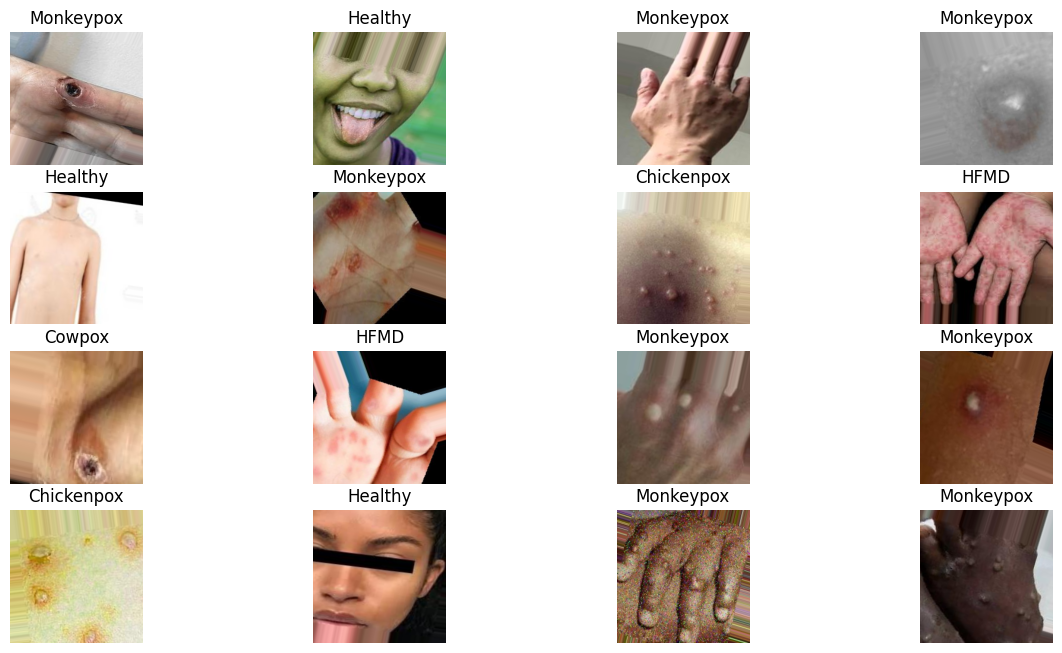

In [9]:
# DIsplay the sample data
a = train_data.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(len(img)):
        plt.subplot(5, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
plot_images(x,y)

In [10]:
def class_distrubution(folder):
  # Calculate class distribution
  class_names = os.listdir(folder)
  class_dis = [len(os.listdir(folder + "/" + name)) for name in class_names]
  fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
  fig.update_layout(title_x = 0.47)
  fig.show()



In [11]:
class_distrubution(train_folder)
#class_distrubution(val_folder)

# Building the Model

## Model 1 : ResNet50

In [12]:
# # Create TensorFlow datasets from ImageDataGenerators(to be continused from above where we created train_data, val_data, test_data from flow_from_directory command)
# train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, train_data.num_classes]))
# val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, val_data.num_classes]))
# test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, test_data.num_classes]))

# # Apply prefetch and autotune
# train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# Callbacks are used to perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).
# In our case, we are using Modelcheckpoint for saving the model weights into the disk for a minimum value of validation loss. Further,
# we are also using ReduceLROnPlateau for reducing the learning rate of the model by a factor of 0.5 if its validation loss doesn’t improve for 3 consecutive epochs.

checkpoint = ModelCheckpoint('.mdl1_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [14]:
# Load the ResNet50 model pretrained on ImageNet data and use fine tuning

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [15]:
conv_base.trainable = True

# Unfreeze some top layers for fine-tuning
for layer in conv_base.layers[-10:]:
    layer.trainable = True

model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation = "softmax"))

# Compile the model
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model.fit(train_data,batch_size=BATCH_SIZE,callbacks=callbacks, validation_data= val_data,epochs=20,verbose=1)

Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 0.9367 - accuracy: 0.7098
Epoch 1: val_accuracy improved from -inf to 0.20130, saving model to .mdl1_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



471/471 [==============================] - 521s 1s/step - loss: 0.9367 - accuracy: 0.7098 - val_loss: 3.4269 - val_accuracy: 0.2013 - lr: 1.0000e-04
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.8570
Epoch 2: val_accuracy improved from 0.20130 to 0.74675, saving model to .mdl1_wts.hdf5
471/471 [==============================] - 503s 1s/step - loss: 0.4350 - accuracy: 0.8570 - val_loss: 1.0619 - val_accuracy: 0.7468 - lr: 1.0000e-04
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.8991
Epoch 3: val_accuracy improved from 0.74675 to 0.79221, saving model to .mdl1_wts.hdf5
471/471 [==============================] - 504s 1s/step - loss: 0.3037 - accuracy: 0.8991 - val_loss: 1.0489 - val_accuracy: 0.7922 - lr: 1.0000e-04
Epoch 4/20
471/471 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.9218
Epoch 4: val_accuracy did not improve from 0.79221
471/471 [==============================]

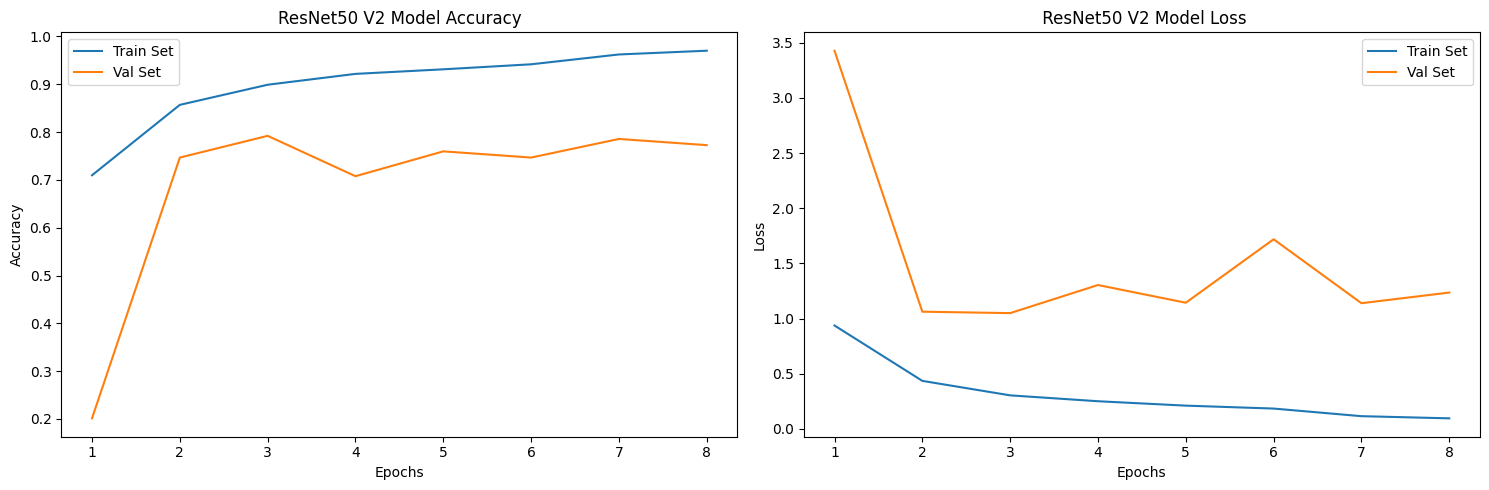

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' ResNet50 V2 Model Loss')

plt.tight_layout()
plt.show()

In [17]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl1_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 4s 276ms/step - loss: 1.0489 - accuracy: 0.7922
[1.048941731452942, 0.7922077775001526]


model performed moderately well on test data with an overall validation accuracy of ---%. But now we will evaluate it on completely unseen test data so that we can assess its performance in a real sense

In [18]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 268ms/step - loss: 1.4072 - accuracy: 0.7143

 Test_Accuracy:- 0.7142857313156128


Confusion Matrix

4/4 [==============================] - 2s 263ms/step
              precision    recall  f1-score   support

           0       0.56      0.71      0.63         7
           1       1.00      0.29      0.44         7
           2       0.75      0.80      0.77        15
           3       0.90      0.90      0.90        10
           4       0.50      0.33      0.40         6
           5       0.68      0.83      0.75        18

    accuracy                           0.71        63
   macro avg       0.73      0.64      0.65        63
weighted avg       0.74      0.71      0.70        63



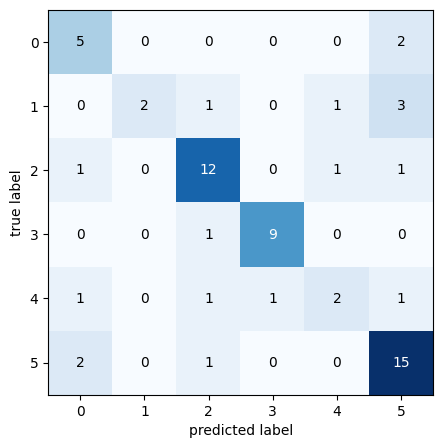

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("ResNet50-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

ResNet50-based Model Accuracy: 71.43%
Precision: 0.731
Recall: 0.644
F1 Score: 0.649


## Model 2: MobileNet V2



In [21]:
conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 1s 0us/step


In [22]:

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [23]:
# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

In [24]:
checkpoint = ModelCheckpoint('.mdl2_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [25]:
history = model.fit(train_data,batch_size=BATCH_SIZE,callbacks=callbacks, validation_data=val_data,epochs=20,verbose=1)

Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 1.6547 - accuracy: 0.4433
Epoch 1: val_accuracy improved from -inf to 0.40909, saving model to .mdl2_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



471/471 [==============================] - 172s 339ms/step - loss: 1.6547 - accuracy: 0.4433 - val_loss: 3.0228 - val_accuracy: 0.4091 - lr: 0.0010
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 1.1238 - accuracy: 0.6204
Epoch 2: val_accuracy improved from 0.40909 to 0.51948, saving model to .mdl2_wts.hdf5
471/471 [==============================] - 158s 336ms/step - loss: 1.1238 - accuracy: 0.6204 - val_loss: 1.7217 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.9039 - accuracy: 0.7055
Epoch 3: val_accuracy did not improve from 0.51948
471/471 [==============================] - 158s 335ms/step - loss: 0.9039 - accuracy: 0.7055 - val_loss: 7.1830 - val_accuracy: 0.2792 - lr: 0.0010
Epoch 4/20
471/471 [==============================] - ETA: 0s - loss: 0.7552 - accuracy: 0.7519
Epoch 4: val_accuracy did not improve from 0.51948

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
47

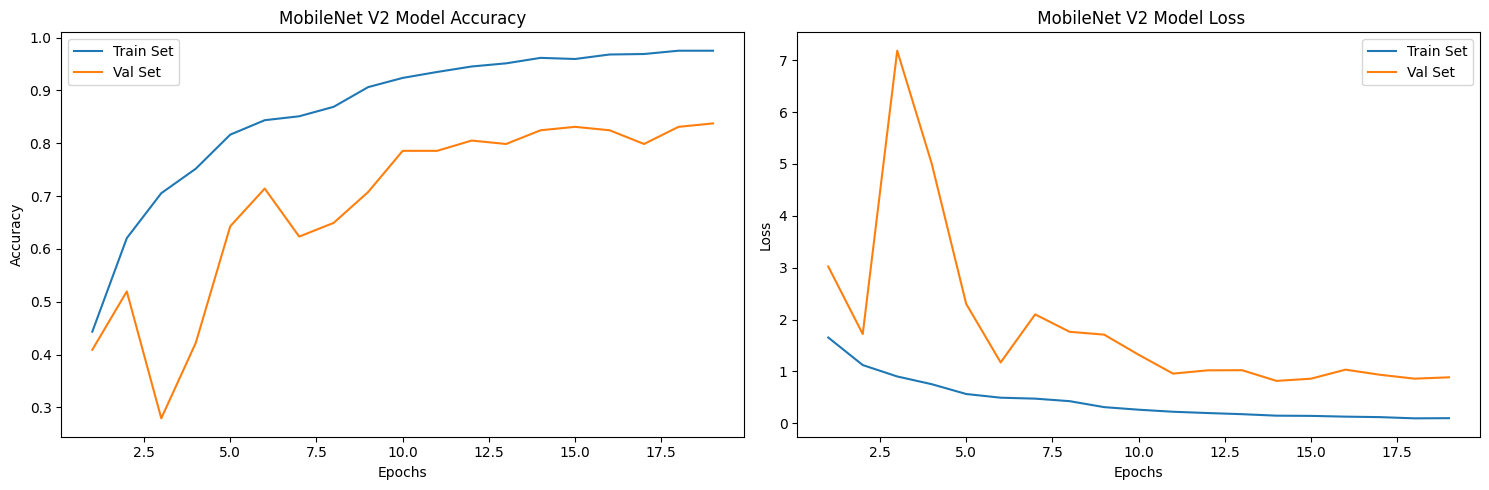

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

In [27]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl2_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 2s 75ms/step - loss: 0.8875 - accuracy: 0.8377
[0.887523889541626, 0.8376623392105103]


In [28]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 0s 77ms/step - loss: 0.6150 - accuracy: 0.8571

 Test_Accuracy:- 0.8571428656578064


4/4 [==============================] - 1s 70ms/step
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.75      0.86      0.80         7
           2       0.88      0.93      0.90        15
           3       1.00      1.00      1.00        10
           4       1.00      0.50      0.67         6
           5       0.76      0.89      0.82        18

    accuracy                           0.86        63
   macro avg       0.90      0.82      0.84        63
weighted avg       0.87      0.86      0.85        63



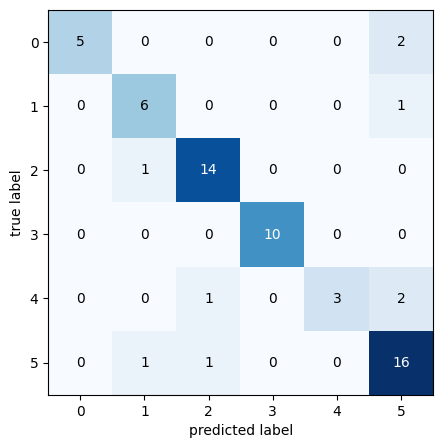

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("MobileNet-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

MobileNet-based Model Accuracy: 85.71%
Precision: 0.898
Recall: 0.816
F1 Score: 0.837


### Model 3 : DenseNet121


In [31]:
checkpoint = ModelCheckpoint('.mdl3_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [32]:
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pretrained on ImageNet data
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Allow fine-tuning of the whole model
conv_base.trainable = True

# Add custom layers on top of the base model
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

# Train the model
history = model.fit(train_data, batch_size=BATCH_SIZE, callbacks=callbacks, validation_data=val_data, epochs=20, verbose=1)


29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.8123
Epoch 1: val_accuracy improved from -inf to 0.81818, saving model to .mdl3_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



471/471 [==============================] - 519s 1s/step - loss: 0.5229 - accuracy: 0.8123 - val_loss: 0.6429 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9270
Epoch 2: val_accuracy did not improve from 0.81818
471/471 [==============================] - 484s 1s/step - loss: 0.2015 - accuracy: 0.9270 - val_loss: 0.9154 - val_accuracy: 0.7468 - lr: 1.0000e-04
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9457
Epoch 3: val_accuracy did not improve from 0.81818

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
471/471 [==============================] - 485s 1s/step - loss: 0.1500 - accuracy: 0.9457 - val_loss: 0.9562 - val_accuracy: 0.7468 - lr: 1.0000e-04
Epoch 4/20
471/471 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9781
Epoch 4: val_accuracy improved from 0.81818 to 0.85065, saving model to .mdl3_wts.hdf5

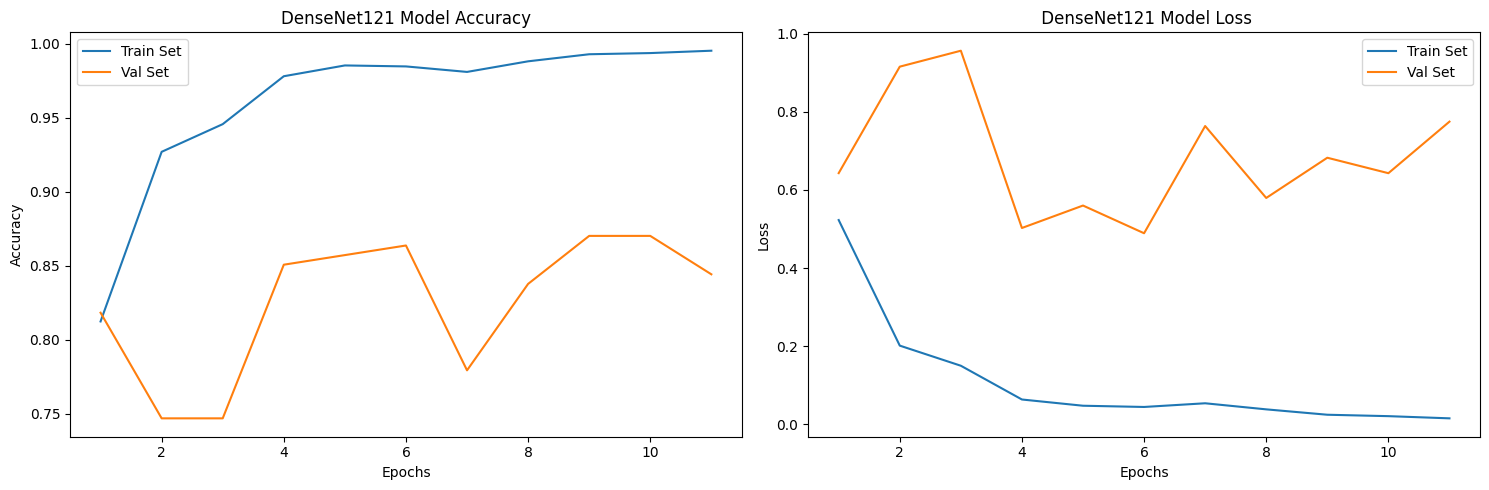

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' DenseNet121 Model Loss')

plt.tight_layout()
plt.show()

In [34]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl3_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 4s 249ms/step - loss: 0.6824 - accuracy: 0.8701
[0.682353138923645, 0.8701298832893372]


In [35]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 264ms/step - loss: 0.4778 - accuracy: 0.8730

 Test_Accuracy:- 0.8730158805847168


4/4 [==============================] - 3s 245ms/step
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       1.00      1.00      1.00         7
           2       0.83      1.00      0.91        15
           3       0.83      1.00      0.91        10
           4       1.00      0.33      0.50         6
           5       0.89      0.89      0.89        18

    accuracy                           0.87        63
   macro avg       0.90      0.82      0.83        63
weighted avg       0.88      0.87      0.86        63



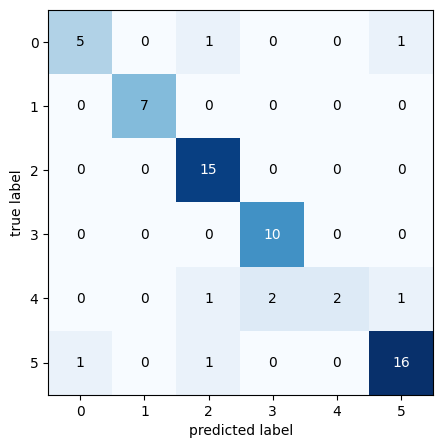

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("DenseNet121-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

DenseNet121-based Model Accuracy: 87.30%
Precision: 0.898
Recall: 0.823
F1 Score: 0.829


In [38]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.preprocessing import image
# import innvestigate

# # Disable eager execution
# tf.compat.v1.disable_eager_execution()

# # Load pre-trained model
# model = ResNet50(weights='imagenet')

# # Create a new model that excludes the softmax layer
# model_without_softmax = tf.keras.Model(
#     inputs=model.input,
#     outputs=model.layers[-2].output  # Output of the layer before softmax
# )

# # Load an image
# img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_12_01.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# # Create an analyzer
# analyzer = innvestigate.create_analyzer("lrp.epsilon", model_without_softmax)

# # Analyze the image
# analysis = analyzer.analyze(x)

# # Postprocess the relevance map
# analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
# analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
# analysis /= analysis.max()  # Normalize to [0, 1]

# # Display the original image
# plt.imshow(img)
# plt.axis('off')
# plt.title('Original Image')
# plt.show()

# # Display the relevance heatmap
# plt.imshow(analysis, cmap="hot", alpha=0.5, interpolation='nearest')
# plt.axis('off')
# plt.title('LRP Heatmap')
# plt.show()


In [39]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
# from tensorflow.keras.preprocessing import image
# import innvestigate

# # Disable eager execution
# tf.compat.v1.disable_eager_execution()

# # Load pre-trained model
# model = DenseNet121(weights='imagenet')

# # Create a new model that excludes the softmax layer
# model_without_softmax = tf.keras.Model(
#     inputs=model.input,
#     outputs=model.layers[-2].output  # Output of the layer before softmax
# )

# # Load an image
# img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_44_01.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# # Create an analyzer
# analyzer = innvestigate.create_analyzer("lrp.epsilon", model_without_softmax)

# # Analyze the image
# analysis = analyzer.analyze(x)

# # Postprocess the relevance map
# analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
# analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
# analysis /= analysis.max()  # Normalize to [0, 1]

# # Display the original image
# plt.imshow(img)
# plt.axis('off')
# plt.title('Original Image')
# plt.show()

# # Display the relevance heatmap
# plt.imshow(analysis, cmap="hot", alpha=0.5, interpolation='nearest')
# plt.axis('off')
# plt.title('LRP Heatmap')
# plt.show()



Instructions for updating:
Colocations handled automatically by placer.


14536120/14536120 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1505: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



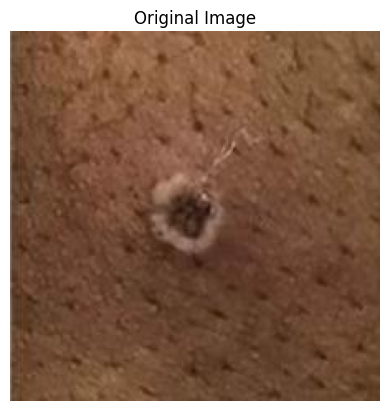

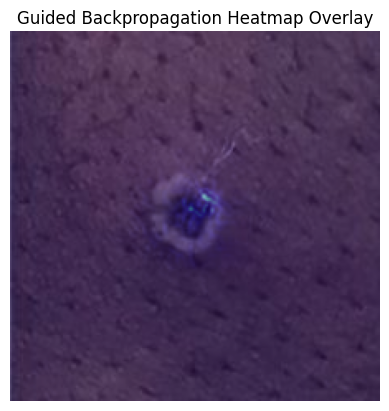

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = MobileNetV2(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_14_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)  # Use Guided Backpropagation

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Overlay the relevance heatmap on the original image
img_original = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
heatmap = cv2.applyColorMap(np.uint8(255 * analysis), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

plt.imshow(overlay)
plt.axis('off')
plt.title('Guided Backpropagation Heatmap Overlay')
plt.show()


102967424/102967424 [==============================] - 6s 0us/step


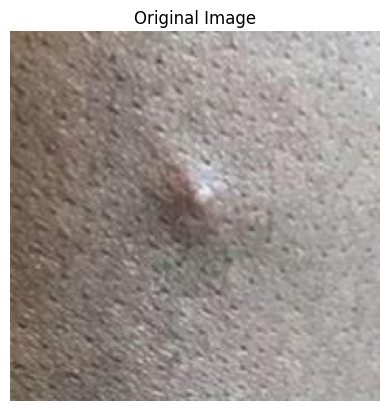

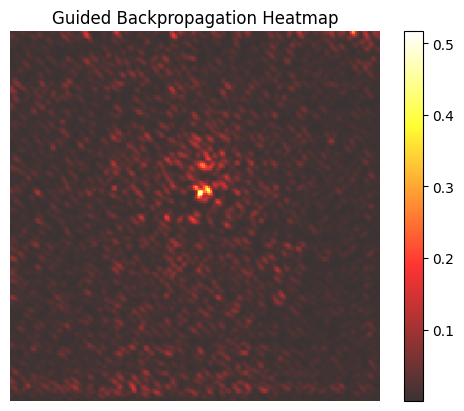

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = ResNet50(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_12_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.8, interpolation='nearest')
plt.axis('off')
plt.title('Guided Backpropagation Heatmap')
plt.colorbar()
plt.show()


33188688/33188688 [==============================] - 3s 0us/step


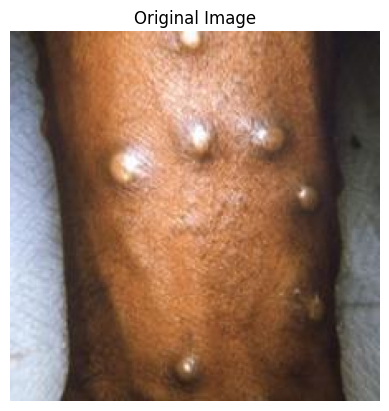

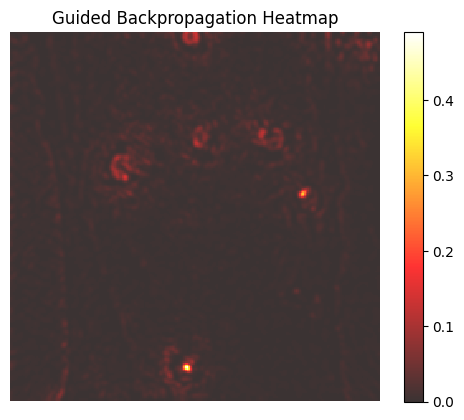

In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = DenseNet121(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_114_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()


# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.8, interpolation='nearest')
plt.axis('off')
plt.title('Guided Backpropagation Heatmap')
plt.colorbar()
plt.show()
